In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split # 데이터 나누기
from sklearn.preprocessing import StandardScaler # 표준화
from sklearn.pipeline import make_pipeline # 파이프라인
from sklearn.metrics import accuracy_score, f1_score # 평가지표
from xgboost import XGBClassifier # 분류모델
from sklearn.model_selection import RandomizedSearchCV # 하이퍼 파라미터 튜닝

In [2]:
# 데이터 불러오기
df = pd.read_csv('./processed_df.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32634 entries, 0 to 32633
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   item_id    32634 non-null  int64  
 1   item_size  32634 non-null  int64  
 2   cup_size   32634 non-null  int64  
 3   hips       32634 non-null  int64  
 4   category   32634 non-null  object 
 5   height     32634 non-null  float64
 6   length     32634 non-null  int64  
 7   fit        32634 non-null  int64  
 8   user_id    32634 non-null  int64  
dtypes: float64(1), int64(7), object(1)
memory usage: 2.2+ MB


<Figure size 400x300 with 0 Axes>

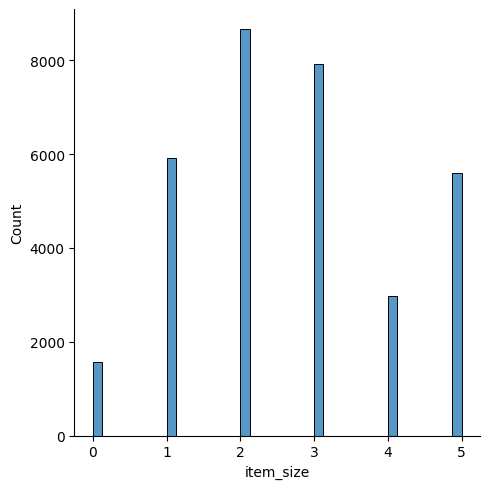

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(4,3))
sns.displot(data=df, x='item_size')
plt.show();

In [4]:
# 데이터 나누기
train, test = train_test_split(df, stratify=df.item_size, test_size=0.3, random_state=2)
train, val = train_test_split(train, stratify=train.item_size, test_size=0.25, random_state=2)

def split(df):
    X = ['cup_size', 'hips', 'height', 'item_size']
    y = 'fit'
    return df[X], df[y]

X_train, y_train = split(train)
X_val, y_val = split(val)
X_test, y_test = split(test)

X_train.shape, X_val.shape, X_test.shape

((17132, 4), (5711, 4), (9791, 4))

In [5]:
# 모델 선언

scaler = StandardScaler()
X_train_prcs = scaler.fit_transform(X_train)
X_val_prcs = scaler.transform(X_val)
X_test_prcs = scaler.transform(X_test)
    
xgb = make_pipeline(
    StandardScaler(),
    XGBClassifier(
        objective='multi:softmax',
        random_state=2,
        learning_rate=0.3,
        num_class = len(set(y_train)),
        n_jobs=-1,
        eval_metric='merror',
        max_depth=2
    )
)
# 모델 학습
xgb.fit(X_train_prcs, y_train)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='merror',
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.3,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=2, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=-1, num_class=3, num_parallel_tree=None,
                               objective='multi:softmax', ...))])

In [6]:
# 모델 학습 성능 확인
train_pred = xgb.predict(X_train_prcs)
val_pred = xgb.predict(X_val_prcs)
test_pred = xgb.predict(X_test_prcs)
print('학습 accuracy:', accuracy_score(y_train, train_pred))
print('검증 accuracy:', accuracy_score(y_val, val_pred))
print('평가 accuracy:', accuracy_score(y_test, test_pred))

학습 accuracy: 0.6864347420032687
검증 accuracy: 0.6872701803537034


In [7]:
# 모델 피클링
import pickle

with open('model.pkl','wb') as pickle_file:
    pickle.dump(xgb, pickle_file)

In [8]:
# y_train_arr = y_train.to_numpy()
# y_val_arr = y_val.to_numpy()
# y_test_arr = y_test.to_numpy()

# y_train_arr.shape